In [6]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('../')

# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT
from s4.dts4 import DecisionS4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [7]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, df, **kwargs):
		results = evaluate_on_env(
			model=self.model, traj_dataset=self.traj_dataset,
			device=self.device, context_len=self.config.context_len,
			env=self.env, rtg_target=self.config.rtg_main,
			num_eval_ep=self.config.num_eval_ep,
			max_test_ep_len=self.config.max_eval_ep_len)
		self.logger.log(
				   model=self.model,
				   loss=df['train/loss'].sum(),
				   eval_avg_reward=results['eval/avg_reward'],
				   eval_avg_ep_len=results['eval/avg_ep_len'],
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})
		res = {}
		for rtg in self.rtgs:
			res[rtg] = evaluate_on_env(
				model=self.model,
				traj_dataset=self.traj_dataset,
				device=self.device,
				context_len=self.config.context_len,
				env=self.env,
				rtg_target=rtg,
				num_eval_ep=self.config.num_eval_ep
			)
		self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_reward'] for res in self.eval_results[n//2:]])
			
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

In [8]:
from minigrid.wrappers import FlatObsWrapper, ImgObsWrapper

env = ImgObsWrapper(DoorKeyEnvSmall()) # wrap the environment to only give the vision data

# todo is this number of trajectories enough?
# todo should the reward scale be 1?
# todo make sure max_steps is not too much. we don't want the context length to be too big
traj_dataset = DoorKeyDataset(env, n_trajectories=2000, reward_scale=None)

collecting trajectories:   0%|          | 0/2000 [00:00<?, ?it/s]

Dataset Info:


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


episode_max_length: 50
reward_scale: 0.0
return min=0, max=0 mean=0.0
gamma: 1


In [9]:
# todo rtg_range_check and rtg_main are used for plotting and monitoring
# todo is the rtg_range_check correct?
config = TrainConfig(max_eval_ep_len=20, context_len=64, rtg_range_check=(0, 5), rtg_main=5)

experiment_name = 'first-small-door-key-experiment'

model = DecisionS4(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			h_dim=config.embed_dim,
			context_len=config.context_len,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

loss_fn = nn.MSELoss(reduction='mean')

trainer = TrainerDT(name=experiment_name, model=model,
					optimizer=optimizer, loss_fn=loss_fn,
					dataset=LimitedContextWrapper(traj_dataset, context_len=config.context_len),
					device=device, config=config, scheduler=scheduler)

callback = CustomCallback(env=env, model=model,
						  optimizer=optimizer, logger=trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

trainer.register_callback(callback.callback)

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

number of parameters 630811


In [10]:
report = trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ComplexMult(Real2Complex(1/ComplexSquareAbs(ComplexMult(b-c,b-Conj(c)))),ComplexMult(b*ComplexReal(a)-Real2Complex(a|c),Conj(ComplexMult(b-c,b-Conj(c))))) with a=Var(0,2,1), b=Var(1,2,0), c=Var(2,2,1) ... OK
[pyKeOps] Compiling pykeops cpp ac621036f6 module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula ComplexAdd(ComplexAdd(ComplexAdd(Zero(2),Zero(2)),ComplexAdd(Zero(2),Zero(2)))*(-1/ComplexSquareAbs(ComplexMult(b-c,b-Conj(c)))**2),ComplexAdd(Real2Complex(ComplexMult(Conj(Conj(ComplexMult(b-c,b-Conj(c)))),ComplexMult(Conj(Real2Complex(1/ComplexSquareAbs(ComplexMult(b-c,b-Conj(c))))),d))|b)-ComplexReal(ComplexMult(Conj(Conj(ComplexMult(b-c,b-Conj(c)))),ComplexMult(Conj(Real2Complex(1/ComplexSquareAbs(ComplexMult(b-c,b-Conj(c))))),d)))*c,ComplexAdd(Zero(2),Zero(2)))) with b=Var(1,2,0), c=Var(2,2,1), d=Var(3,2,0) ... OK
[pyKeOps] Compiling pykeops cpp 102173eeba m

/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:00:18
num of updates: 100
loss: 0.00000
eval avg reward: 0.00000
best score: -inf
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00001


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:00:37
num of updates: 200
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00002


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:00:56
num of updates: 300
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00003


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:01:16
num of updates: 400
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00004


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:01:36
num of updates: 500
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00005


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:01:56
num of updates: 600
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00006


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:02:17
num of updates: 700
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00007


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:02:37
num of updates: 800
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00008


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:02:58
num of updates: 900
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00009


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:03:19
num of updates: 1000
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00010


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:03:39
num of updates: 1100
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00011


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:04:00
num of updates: 1200
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00012


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:04:19
num of updates: 1300
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00013


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:04:37
num of updates: 1400
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00014


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:04:56
num of updates: 1500
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00015


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:05:15
num of updates: 1600
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00016


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:05:37
num of updates: 1700
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00017


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:05:56
num of updates: 1800
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00018


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:06:16
num of updates: 1900
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00019


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:06:36
num of updates: 2000
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00020


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:06:57
num of updates: 2100
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00021


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:07:18
num of updates: 2200
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00022


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:07:39
num of updates: 2300
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00023


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:08:00
num of updates: 2400
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00024


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:08:22
num of updates: 2500
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00025


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:08:43
num of updates: 2600
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00026


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:09:03
num of updates: 2700
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00027


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:09:23
num of updates: 2800
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00028


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:09:43
num of updates: 2900
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00029


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:10:04
num of updates: 3000
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00030


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:10:24
num of updates: 3100
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00031


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:10:45
num of updates: 3200
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00032


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:11:06
num of updates: 3300
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00033


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:11:27
num of updates: 3400
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00034


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:11:47
num of updates: 3500
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00035


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:12:08
num of updates: 3600
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00036


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:12:28
num of updates: 3700
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00037


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:12:50
num of updates: 3800
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00038


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:13:10
num of updates: 3900
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00039


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:13:31
num of updates: 4000
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00040


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:13:53
num of updates: 4100
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00041


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:14:13
num of updates: 4200
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00042


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:14:33
num of updates: 4300
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00043


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:14:54
num of updates: 4400
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00044


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:15:14
num of updates: 4500
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00045


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:15:34
num of updates: 4600
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00046


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:15:55
num of updates: 4700
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00047


/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return value / self.scale
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../data/convertor.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return value / self.scale


achieved average reward:  0.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-10-08-25-09_best.pt
time elapsed: 0:16:16
num of updates: 4800
loss: 0.00000
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm nan
lr 0.00048


KeyboardInterrupt: 

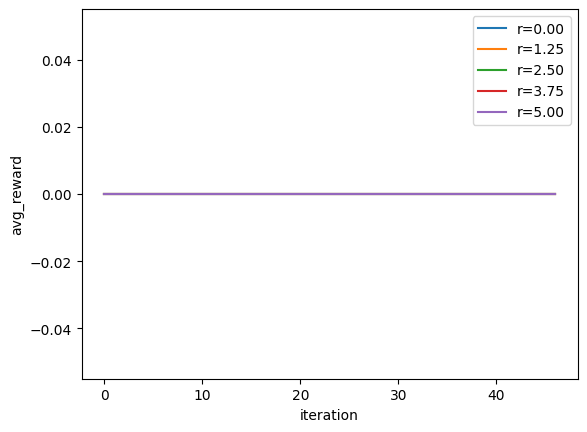

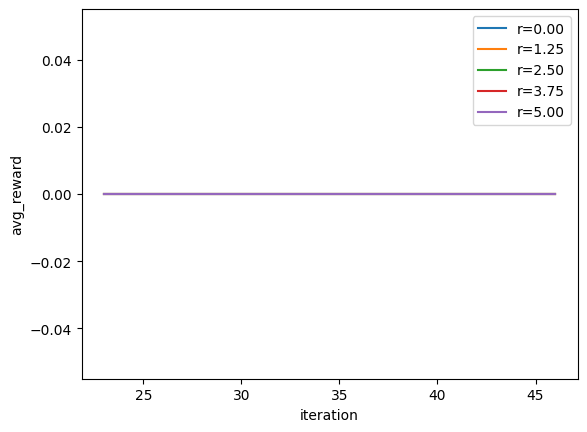

In [11]:
callback.plot_eval_results()

In [12]:
report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()

NameError: name 'report' is not defined